<a href="https://colab.research.google.com/github/alexandergribenchenko/DS_LATAM_Test/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cuál es la probabilidad de que se retrase mi vuelo?
**Data Scientist Challenge - LATAM Airlines (Presentado por: Alexander Ortega, Marzo 2023)**



Este notebook presenta la solución al reto analítico propuesto por LATAM que consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).
 
El notebook está compuesto de 5 secciones que dan respuesta a cada uno de los ítems descritos en la sección de `Desafío`:
 
- **Sección 01. Distribución de los datos:** se analiza la distribución de los datos para cada uno de los features que componen el dataset.
- **Sección 02. Generación de columnas adicionales:** se genera un dataset denominado `synthetic_features.csv` con las columnas adicionales que dan cuenta de la temporada (alta o baja), el retraso en minutos, la etiqueta de atrasado (si, no) si el retraso es superior a 15 minutos y por último en periodo del día (mañana, tarde o noche).
- **Sección 03. Comportamiento del atraso vs features relevantes:** se describe la relación entre la variable de retraso y las variables destino, aerolínea, mes del año, día de la semana, temporada y tipo de vuelo. A partir de sus resultados se discuten cuáles son las que pueden presentar mayor relevancia en el modelo.
- **Sección 04. Entrenamiento de modelos propuestos:** se presenta el pipeline que compone el procesamiento de datos y entrenamiento de 3 modelos base: Logistic Regression, Decision Tree Classifier y Xgboost. De manera adicional se presenta la alternativa para la evaluación de un conjunto más amplio de modelos a partir del uso de la librería de AutoML Pycaret.
- **Sección 05. Evaluación de modelos propuestos:** se discute la métrica elegida para evaluar el performance del modelo y se presentan los resultados para cada uno de los modelos. Así mismo se discuten las variables que mayor influencia presentan en la predicción y algunas alternativas para mejorar su performance.


# A. Líbrerías

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install pycaret > /dev/null
import pycaret
from pycaret.classification import *

# B. Dataframe raw

In [3]:
path_github = 'https://raw.githubusercontent.com/alexandergribenchenko/DS_LATAM_Test/main/data/dataset_SCL.csv'

In [4]:
df_raw = pd.read_csv(path_github, dtype=object)
df_raw

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  object
 11  MES        68206 non-null  object
 12  AÑO        68206 non-null  object
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: object(18)
memory usage: 9.4+ MB


# Sección 01. Distribución de los datos

# Sección 02. Generación de Columnas Adicionales

En esta sección se genera un dataset denominado `synthetic_features.csv` con las columnas adicionales que dan cuenta de la temporada (alta o baja), el retraso en minutos, la etiqueta de atrasado (si o no) si el retraso es superior a 15 minutos y por último en periodo del día (mañana, tarde o noche).


### ---> Aproximación de la solución:
Esta sección se desarrolla empleando en uso transformadores y pipelines bajo la aproximación de programación OOP. Si bien el procedimiento para un proceso de transformación simple puede prescindir de ello, la idea de esta aproximación presenta algunas ventajas:
- **Estandarización del desarrollo:**  se pueda contar con transformadores y pipelines que estandarizan los procedimientos garantizando que se estarán haciendo de la misma manera sobre cualquier conjunto de datos. 
- **Facilita pruebas unitarias**: dado que los transformadores y pipelines cumplen con tareas específicas se pueden facilitar las pruebas unitarias sobre el desarrollo.
- **Parametrización y agilidad en el desarrollo:** permite que el desarrollo sea fácilmente parametrizable pues cambiando únicamente las entradas de los transformadores se pueden crear nuevos pipelines para necesidades específicas.

## 02.01. Definición de los Transformadores

### ---> FeatureSelector
Filtra las columnas seleccionadas en el dataset de entrada.

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_FeatureSelector):
        self.feature_names = params_FeatureSelector['feature_names'] 
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
      X_output = X[self.feature_names]
      return X_output

### ---> DateType
Convierte a formato `datetime` las columnas seleccionadas.

In [7]:
class DateType(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_FeatureSelector):
        self.cols_dates = params_DateType['cols_dates'] 
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
      X_output = X.copy()
      for col in self.cols_dates:
        X_output[col] = pd.to_datetime(X_output[col])
      return X_output

### ---> TemporadaAlta
Crea la columna `temporada_alta` a partir de una columna de fecha que se le especifíque. 

EL criterio usado es: 
- temporada_alta(1): si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep.
- temporada_alta(0): si es diferente a las fechas descritas en 1.

In [8]:
class TemporadaAlta(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_TemporadaAlta):
        self.columna_fecha = params_TemporadaAlta['columna_fecha'] 
    
    def fit(self, X, y = None):
        return self

    def fun_temporada_alta(self, fecha):
      mes = fecha.month
      dia = fecha.day
      if (mes == 12 and dia >= 15) or \
      (mes in [1, 2]) or \
      (mes == 3 and dia <= 3) or \
      (mes == 7 and (dia >= 15 and dia <= 31)) or \
      (mes == 9 and (dia >= 11 and dia <= 30)):
          return 1
      else:
          return 0
    
    def transform(self, X, y = None):
      X_output = X.copy()
      X_output['temporada_alta'] = X_output[self.columna_fecha].apply(self.fun_temporada_alta)
      return X_output

### ---> DifMin
Crea la columna `dif_min` que es la diferencia en minutos entre Fecha-O y Fecha-I. Básicamante el tiempo en minutos que se retraso el vuelo.

In [9]:
class DifMin(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_DifMin):
        self.empty = params_DifMin 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      X_output = X.copy()
      X_output['dif_min'] = (X_output['Fecha-O']-X_output['Fecha-I'])/pd.Timedelta(minutes=1)
      return X_output

### ---> Atraso15
Crea la columna `atraso_15` a partir de una columna `dif_min`. Esta columna es la que servirá como target en nuestro modelo de clasificación.

EL criterio usado es: 
- temporada_alta(1): si dif_min > 15
- temporada_alta(0): si dif_min <= 15

In [10]:
class Atraso15(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_Atraso15):
        self.empty = params_Atraso15 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
      X_output = X.copy()
      X_output['atraso_15'] = (X_output['dif_min'] > 15).astype(int)
      return X_output

### ---> PeriodoDia
Crea la columna `periodo_dia` a partir de una columna de fecha que se le especifíque. 

EL criterio usado es: 
- periodo_dia(mañana): entre 5:00 y 11:59 hrs.
- periodo_dia(tarde): entre 12:00 y 18:59 hrs.
- periodo_dia(noche): entre 19:00 y 4:59 hrs.



In [11]:
class PeriodoDia(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_PeriodoDia):
        self.columna_fecha = params_PeriodoDia['columna_fecha'] 
    
    def fit(self, X, y = None):
        return self

    def fun_periodo_dia(self, fecha):
      hora = fecha.hour
      if hora >= 5 and hora <= 11:
          return 'mañana'
      elif hora >= 12 and hora <= 18:
          return 'tarde'
      else:
          return 'noche'
    
    def transform(self, X, y = None):
      X_output = X.copy()
      X_output['periodo_dia'] = X_output[self.columna_fecha].apply(self.fun_periodo_dia)
      return X_output

### ---> OrderOutput
Filtra las columnas seleccionadas en el dataset de entrada. Lo usamos para obtener las columnas que deseamos en el dataset de salida.

In [12]:
class OrderOutput(BaseEstimator, TransformerMixin):
    
    def __init__(self, params_OrderOutput):
        self.feature_names = params_OrderOutput['feature_names'] 
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
      X_output = X[self.feature_names]
      return X_output

## 02.02. Definición de Pipeline

### ---> Parámetros de los transformadores
Definimos cada uno de los parámetros de entrada que deben tener los transformadores para nuestro pipeline.

In [13]:
params_FeatureSelector = {}
params_FeatureSelector['feature_names']= ['Fecha-I', 
                                          'Des-I',
                                          'Emp-I', 
                                          'TIPOVUELO', 
                                          'Fecha-O',
                                         ]

params_DateType = {}
params_DateType['cols_dates']= ['Fecha-I', 'Fecha-O']

params_TemporadaAlta = {}
params_TemporadaAlta['columna_fecha']= 'Fecha-I'

params_DifMin = {}

params_Atraso15 = params_DifMin

params_PeriodoDia = params_TemporadaAlta

params_OrderOutput = {}
params_OrderOutput['feature_names']= ['temporada_alta',
                                      'dif_min',
                                      'atraso_15',	
                                      'periodo_dia'
                                         ]

### ---> Instanciamiento de los Transformadores

Instanciamos nuestros transformadores.

In [14]:
Transformer_FeatureSelector = FeatureSelector(params_FeatureSelector)
Transformer_DateType = DateType(params_DateType)
Transformer_TemporadaAlta = TemporadaAlta(params_TemporadaAlta)
Transformer_DifMin = DifMin(params_DifMin)
Transformer_Atraso15 = Atraso15(params_Atraso15)
Transformer_PeriodoDia = PeriodoDia(params_PeriodoDia)
Transformer_OrderOutput = OrderOutput(params_OrderOutput)

### ---> Instanciamiento del Pipeline
Instanciamos el pipeline que dará origen al dataset `synthetic_features.csv`.

In [15]:
pipeline_synthetic_features = Pipeline(steps=[('NameFeatureSelector', Transformer_FeatureSelector),
                              ('NameDateType', Transformer_DateType),
                              ('NameTemporadaAlta', Transformer_TemporadaAlta),
                              ('NameDifMin', Transformer_DifMin),
                              ('NameDateAtraso15', Transformer_Atraso15),
                              ('NamePeriodoDia', Transformer_PeriodoDia),
                              ('NameOrderOutput', Transformer_OrderOutput)
                              ])

## 02.03. Generación del dataframe solicitado
Generamos el dataset solicitado con las 4 columnas y lo almacenamos. Esta dataset posteriormente se mueve y queda almacenado en el folder `data` del repositorio principal.

**Supuesto**: se asume que se desean únicamente las 4 columnas descritas en este archivo. Si se desearan otras adicionales solo se deberían cambiar los parámetros de los transformadores FeatureSelector y OrderOutput.

In [16]:
df_synthetic_features = pipeline_synthetic_features.transform(df_raw)
df_synthetic_features

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche
...,...,...,...,...
68201,1,46.0,1,tarde
68202,1,16.0,1,tarde
68203,1,40.0,1,tarde
68204,1,13.0,0,tarde


In [17]:
df_synthetic_features.to_csv('synthetic_features.csv', index=False)

# Sección 03. Composición de la tasa de atraso

En la presente sección se describe la relación entre la variable de retraso y las variables destino, aerolínea, mes del año, día de la semana, temporada y tipo de vuelo. Para cada una de las variables hay una pequeña discución de los elementos mas relevantes que presentan sus distribuciiones, y en el numeral final de la sección se discuten cuáles son las que se estima pueden presentar mayor relevancia en el modelo. 

### ---> Aproximación de la solución:
Esta sección se presentan para cada una de las variables descritas una tabla con las siguientes variables:
- `porcentaje_vuelos_con_atraso`: porcentaje de vuelos dentro del grupo de interes que presentaron retraso. 
- `porcentaje_vuelos_sin_atraso`: porcentaje de vuelos dentro del grupo de interes que no presentaron retraso.
- `vuelos_con_atraso`: cantidad de vuelos dentro del grupo de interes que presentaron retraso.
- `vuelos_sin_atraso`: cantidad de vuelos dentro del grupo de interes que no presentaron retraso.

A su vez, tambien se presentan 2 gráficos para cada una de las variables: 
- `Gráfico izquierdo (absoluto por grupo)`: presenta la cantidad de vuelos (totales, sin atraso y con atraso) organizados descendentemente en relación con el grupo que mayores atrasos presenta. Es decir permite evidenciar en cantidad, cuales son los grupos que de manera absoluta que más aportan a los retrasos.
- `Grafico derecho (relativo por grupo)`: presenta de manera porcentual la taza de vuelos con y sin retraso para cada uno de los grupos. Esta organizado descendentemente acorde al grupo que mayor porcentaje de retraso presenta. Nos permite evidenciar intpendientemente de la cantidad de vuelos cual es grupo presentas más retrasos de manera porcentual.



### ---> Dataset preparado para el numeral:

In [18]:
columnas_interes = ['SIGLADES','OPERA', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO', 'atraso_15']
df_atraso = pd.concat([df_raw, df_synthetic_features], axis=1)[columnas_interes]
df_atraso['temporada_alta'] = df_atraso['temporada_alta'].astype(str)
df_atraso

,SIGLADES,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO,atraso_15
0,Miami,American Airlines,1,Domingo,1,I,0
1,Miami,American Airlines,1,Lunes,1,I,0
2,Miami,American Airlines,1,Martes,1,I,0
3,Miami,American Airlines,1,Miercoles,1,I,0
4,Miami,American Airlines,1,Jueves,1,I,0
...,...,...,...,...,...,...,...
68201,Lima,JetSmart SPA,12,Viernes,1,I,1
68202,Lima,JetSmart SPA,12,Lunes,1,I,1
68203,Lima,JetSmart SPA,12,Miercoles,1,I,1
68204,Lima,JetSmart SPA,12,Viernes,1,I,0


### ---> Funciones para la generación de la tabla y gráficos del numeral:

In [19]:
def dataframe_atraso_por(df_atraso, col_interes):
  df_output = df_atraso.groupby([col_interes], as_index=False).\
                            agg(porcentaje_vuelos_con_atraso = ('atraso_15', lambda x: round(100*(x == 1).sum()/x.count(),2)),
                                porcentaje_vuelos_sin_atraso = ('atraso_15', lambda x: round(100*(x == 0).sum()/x.count(),2)),
                                vuelos_con_atraso = ('atraso_15', lambda x: (x == 1).sum()), 
                                vuelos_sin_atraso = ('atraso_15', lambda x: (x == 0).sum()),
                                vuelos_total=('atraso_15', 'count'),
                                ).\
                            sort_values(by=[col_interes], ascending=[True])

  return df_output

In [20]:
def plot_absoluto_porcentual(df_atraso_por_destino, col_interes, width, length):

  order_absoluto = list(df_atraso_por_destino.sort_values(by=['vuelos_con_atraso'], ascending=[False])[col_interes])
  order_porcentual = list(df_atraso_por_destino.sort_values(by=['porcentaje_vuelos_con_atraso'], ascending=[False])[col_interes])

  fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False)
  fig.set_size_inches(width, length)
  fig.subplots_adjust(wspace=0.5)

  # Grafico derecho: Absoluto
  sns.set_color_codes("pastel")
  sns.barplot(ax=axs[0], x="vuelos_total", y=col_interes, data=df_atraso_por_destino,
              label="Total", color="g", order=order_absoluto)

  sns.set_color_codes("muted")
  sns.barplot(ax=axs[0], x="vuelos_sin_atraso", y=col_interes, data=df_atraso_por_destino,
              label="vuelos_sin_atraso", color="b", order=order_absoluto )

  sns.barplot(ax=axs[0], x="vuelos_con_atraso", y=col_interes, data=df_atraso_por_destino,
              label="vuelos_con_atraso", color="r", order=order_absoluto)

  axs[0].legend(ncol=3, loc="upper right", bbox_to_anchor=(1,1.05), frameon=True)
  axs[0].set_xlabel("Cantidad de vuelos")
  axs[0].set_ylabel("")

  # Grafico derecho: Porcentual
  sns.set_color_codes("muted")
  sns.barplot(ax=axs[1], x="porcentaje_vuelos_sin_atraso", y=col_interes, data=df_atraso_por_destino,
              label="porcentaje_vuelos_sin_atraso", color="b", order=order_porcentual, alpha=0.7)

  sns.barplot(ax=axs[1], x="porcentaje_vuelos_con_atraso", y=col_interes, data=df_atraso_por_destino,
              label="porcentaje_vuelos_con_atraso", color="r", order=order_porcentual, alpha=0.7)

  axs[1].legend(ncol=2, loc="upper right", bbox_to_anchor=(1,1.05), frameon=True)
  axs[1].set_xlabel("Porcentaje")
  axs[1].set_ylabel("")
  axs[1].set_xlim(0, 100)

  plt.show()

## 03.01. Tasa de atraso por destino

Principales hallazgos:
- Existe una diferencia importante en los valores absolutos para cada uno de los destinos (una fracción pequeña de destino vuelos, representa una cantidad importante de la totalidad de los vuelos). 
- De manera general que los destinos que mayor tasa absoluta de retraso presentan, son los que presentan al mismo tiempo una mayor cantidad total de vuelos.
- Sin embargo, si evaluamos porcentualmente cuales son los destinos que presentan mayores retrasos porcentuales, estos no corresponden de manera general con los que de manera absoluta presentan las mayores retrasos.


Posible tratamiento para los datos y para el problema de negocio:
- Acorde al problema de negocio los 2 frentes son problemáticos: tanto las rutas que presentan de manera absoluta muchas retrasos, aunque tengan muchos vuelos, así como las rutas que aunque tengan pocas retrasos (quiza aun mas molesto para los usuarios, porque aun con pocos vuelos los retrasos son muy frecuentes). 
- Un posible criterio para atender este problema es fijar un umbral a partir de un percentil (Q3 por ejemplo) a partir del cual deban priorizar la atención para los vuelos que superen el umbral ya sea de manera relativa o absoluta. 

Posible tratamiento de los datos para el modelo:
- Si se quisiera reducir la cardinalidad de esta variable (dada la gran cantidad de destinos) podrían analizarse diferentes criterios de agregación. El de la distribución por percentiles puede ser uno de ellos, pero debería explorarse con mayor detalle en caso de que sea necesario.

**Nota:** todos los valores descritos de manera general podrian cálcularse en detalle en caso de ser necesario. Por el alcance y tiempo de la prueba no se desarrollan con mayor detalle.

In [21]:
df_atraso_por_destino = dataframe_atraso_por(df_atraso, 'SIGLADES')
df_atraso_por_destino

,SIGLADES,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Antofagasta,14.64,85.36,847,4939,5786
1,Arica,13.55,86.45,330,2106,2436
2,Asuncion,28.45,71.55,66,166,232
3,Atlanta,5.87,94.13,21,337,358
4,Auckland N.Z.,37.40,62.60,135,226,361
...,...,...,...,...,...,...
57,Toronto,31.45,68.55,89,194,283
58,Tucuman,26.32,73.68,10,28,38
59,Ushuia,66.67,33.33,4,2,6
60,Valdivia,15.54,84.46,117,636,753


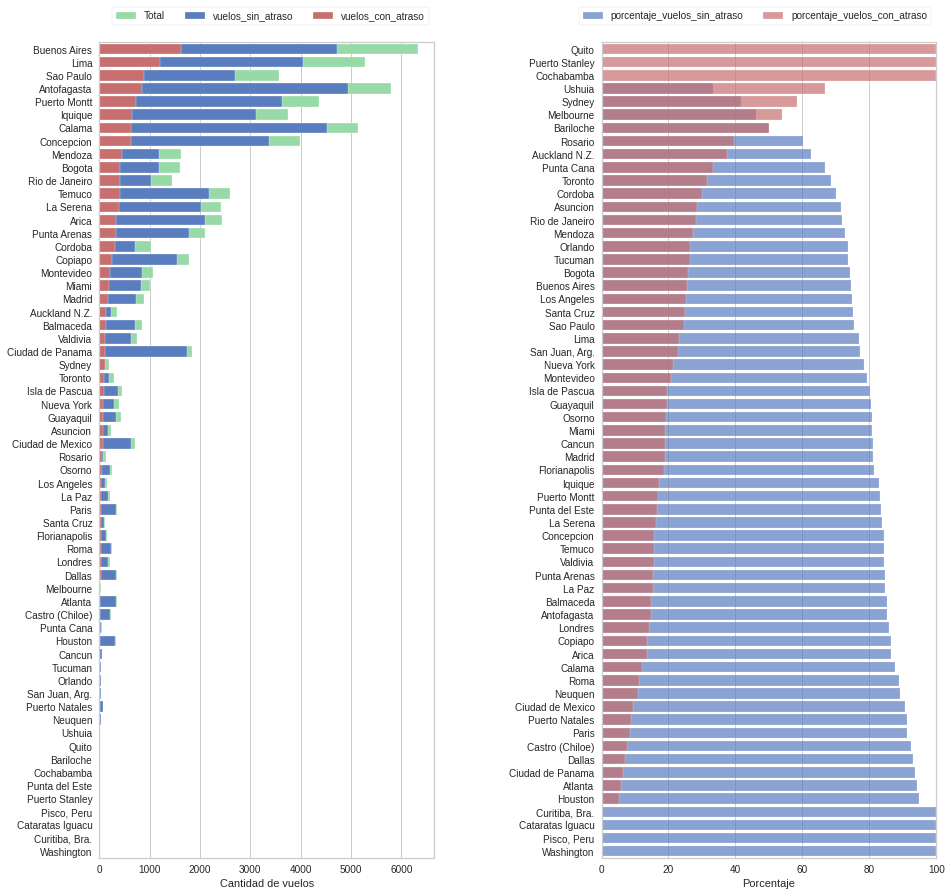

In [22]:
plot_absoluto_porcentual(df_atraso_por_destino, 'SIGLADES', 15, 15)

## 03.02. Tasa de atraso por aerolinea

Los hallazgos y el posible tratamiento para los datos y para el problema de negocio, es similar al ya descrito para la variable destino `destino`.

In [23]:
df_atraso_por_aerolinea = dataframe_atraso_por(df_atraso, 'OPERA')
df_atraso_por_aerolinea

,OPERA,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Aerolineas Argentinas,24.01,75.99,468,1481,1949
1,Aeromexico,2.85,97.15,10,341,351
2,Air Canada,45.66,54.34,258,307,565
3,Air France,8.38,91.62,30,328,358
4,Alitalia,11.20,88.80,29,230,259
5,American Airlines,6.74,93.26,51,706,757
6,Austral,20.27,79.73,15,59,74
7,Avianca,26.56,73.44,306,846,1152
8,British Airways,14.15,85.85,29,176,205
9,Copa Air,6.27,93.73,116,1734,1850


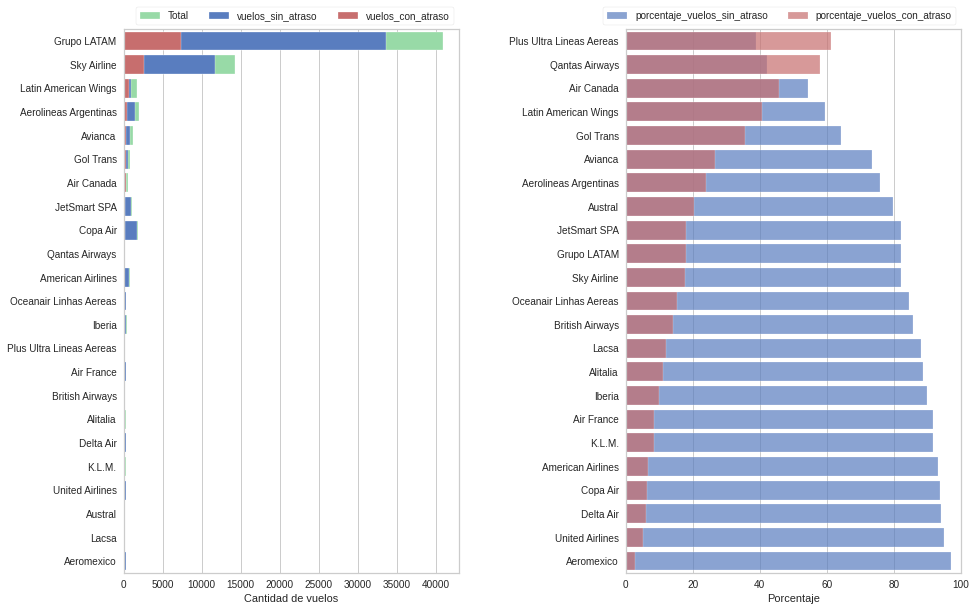

In [24]:
plot_absoluto_porcentual(df_atraso_por_aerolinea, "OPERA", 15, 10)

## 03.03. Tasa de atraso por mes del año

Principales hallazgos:
- Si bien existe una diferencia entre los valores absolutos de los grupos, esta diferencia no es tan significativa como en el caso de los destinos y las aerolíneas. 
- Por lo anterior de manera general el orden tanto de manera absoluta como relativa se conserva.
- Se observa que varios de los meses que presentan mayores retrasos se encuentran también en temporadas altas (julio, diciembre) y que el último trimestre del año es el periodo con mayores retrasos.
- Si se desea reducir la cardinalidad podría explorarse la opción de los trimestres como forma de agregación.


In [25]:
df_atraso_por_mes = dataframe_atraso_por(df_atraso, 'MES')
df_atraso_por_mes

,MES,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,1,16.01,83.99,978,5130,6108
1,10,22.60,77.40,1363,4669,6032
2,11,19.72,80.28,1199,4881,6080
3,12,25.41,74.59,1615,4741,6356
4,2,15.16,84.84,843,4718,5561
5,3,11.51,88.49,631,4851,5482
6,4,11.65,88.35,585,4435,5020
7,5,15.78,84.22,827,4413,5240
8,6,17.10,82.90,852,4129,4981
9,7,29.34,70.66,1758,4234,5992


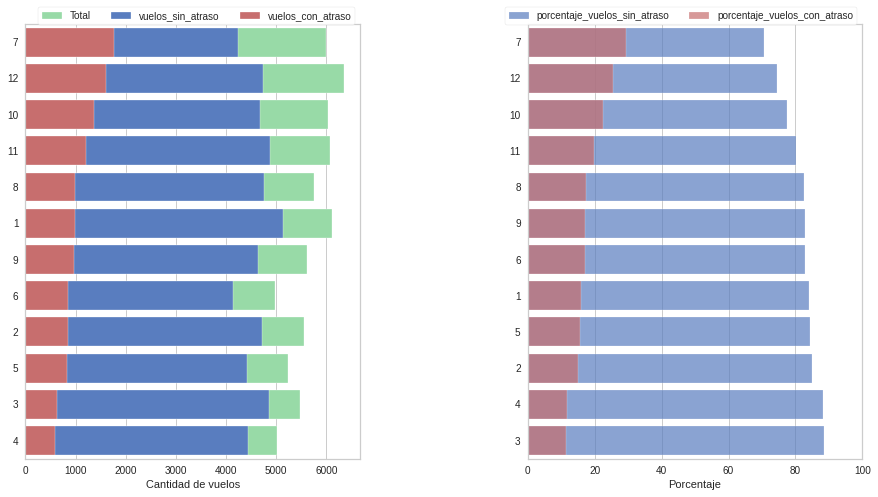

In [26]:
plot_absoluto_porcentual(df_atraso_por_mes, 'MES', 15, 8)

## 03.04. Tasa de atraso por día de la semana

Los hallazgos son similares para el mes de año, con los viernes y los lunes como grupos mayoritarios, y los domingos y sábados como grupos minoritarios.

In [27]:
df_atraso_por_dia_semana = dataframe_atraso_por(df_atraso, 'DIANOM')
df_atraso_por_dia_semana

,DIANOM,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,Domingo,16.11,83.89,1578,8218,9796
1,Jueves,19.95,80.05,2045,8206,10251
2,Lunes,20.22,79.78,2048,8083,10131
3,Martes,16.91,83.09,1634,8028,9662
4,Miercoles,17.08,82.92,1661,8061,9722
5,Sabado,16.32,83.68,1363,6989,8352
6,Viernes,22.20,77.80,2285,8007,10292


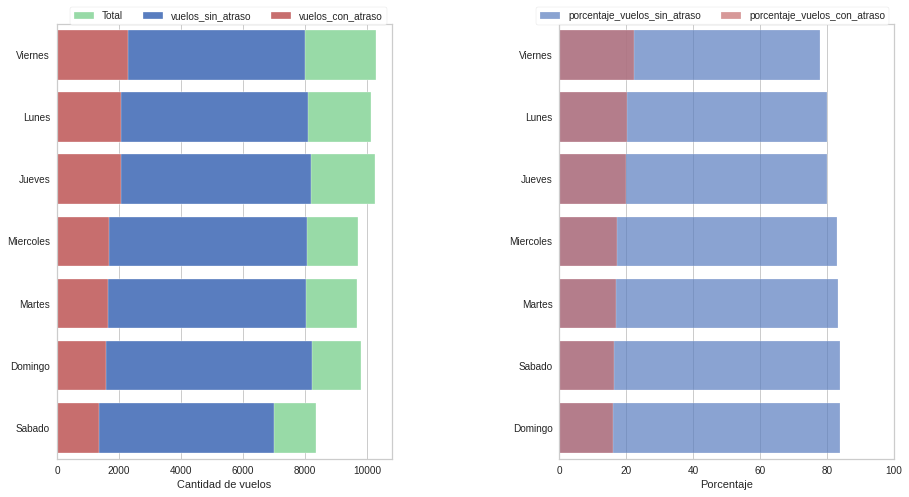

In [28]:
plot_absoluto_porcentual(df_atraso_por_dia_semana, 'DIANOM', 15, 8)

## 03.05. Tasa de atraso por temporada

Aunque de manera absoluta hay una diferencia casi del doble tanto en la cantidad de vuelos como de retrasos, de manera relativa el comportamiento de las temporadas es casi similar.

In [29]:
df_atraso_por_temporada = dataframe_atraso_por(df_atraso, 'temporada_alta')
df_atraso_por_temporada

,temporada_alta,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,0,17.92,82.08,8144,37300,45444
1,1,19.64,80.36,4470,18292,22762


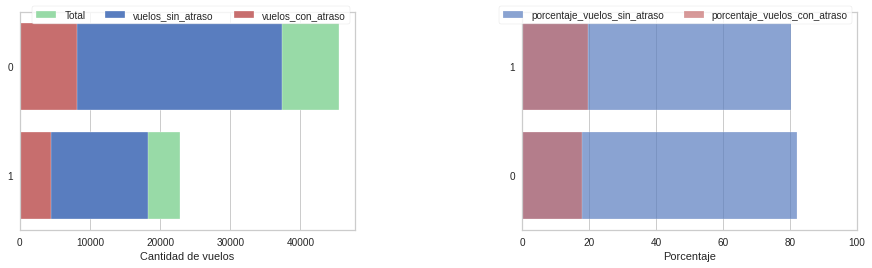

In [30]:
plot_absoluto_porcentual(df_atraso_por_temporada, 'temporada_alta', 15, 4)

## 03.06. Tasa de atraso por tipo de vuelo

Puede notarse que aun cuando hay una menor cantidad de vuelos internacionales que nacionales, los primero presentan una mayor cantidad de atrasos, por lo cual parece ser una característica relevante, que evidentemente podría relacionarse con la variable de destino, si se incluyera información extra en el dataset.

In [31]:
df_atraso_por_tipo_vuelo = dataframe_atraso_por(df_atraso, 'TIPOVUELO')
df_atraso_por_tipo_vuelo

,TIPOVUELO,porcentaje_vuelos_con_atraso,porcentaje_vuelos_sin_atraso,vuelos_con_atraso,vuelos_sin_atraso,vuelos_total
0,I,22.56,77.44,7048,24192,31240
1,N,15.06,84.94,5566,31400,36966


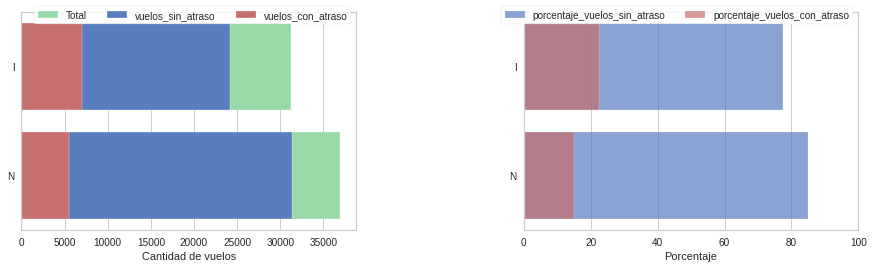

In [32]:
plot_absoluto_porcentual(df_atraso_por_tipo_vuelo, 'TIPOVUELO', 15, 4)

## 03.07. Expectativa en relación a las variables más influyentes en el modelo

Acorde a los hallazgos presentados el conjunto de numerales anteriores se espera que las variables que puedan llegar a tener mayor relevancia en el modelo son inicialmente el destino y la aerolínea pues son las que de manera relativa presentan una distribución muy diferenciada para sus grupos. Si bien son variables categóricas de alta cardinalidad, pueden intentar trabajarse como están (si el volumen de datos no es muy grande), o puede analizarse el criterio de agregación para tener grupos más reducidos (como el de la tasa de cancelación por ejemplo). 

Indirectamente también en el destino también ya estaría incluido si el vuelo es internacional o no, que es otro criterio que muestra alguna relevancia. 

Las variables restantes como el periodo de al año y el dia de la seman también se estima que tendrán contribución pero se espera que sea menos que las inicialmente descritas.



# Sección 04. Entrenamiento de modelos propuestos

En la actual sección se presenta el pipeline que compone el procesamiento de datos y entrenamiento de 3 modelos base: Logistic Regression, Decision Tree Classifier y Xgboost. De manera adicional se presenta la alternativa para la evaluación de un conjunto más amplio de modelos a partir del uso de la librería de AutoML Pycaret.

## 04.01. Generación del dataset base para el entrenamiento y evaluación de los modelos

### ---> Parámetros de los transformadores
Definimos cada uno de los parámetros de entrada que deben tener los transformadores para nuestro pipeline. Incluimos columnas adicionales para que en la salida esten todas las columnas que deseamos evaluar. 

Las únicas columnas que incluiremos como entrada serán aquellas que se pueden tener al momento de hacer una predicción Es decir las que tienen asociado el índice `I` que se asume debe corresponder a Itinerado. No tiene sentido alguno incluir las columnas con la característica de operador pues estas no se conocen al momento de hacer la predicción.

In [33]:
params_FeatureSelector = {}
params_FeatureSelector['feature_names']= ['Fecha-I', 
                                          'Des-I',
                                          'Emp-I', 
                                          'TIPOVUELO', 
                                          'Fecha-O',
                                         ]

params_DateType = {}
params_DateType['cols_dates']= ['Fecha-I', 'Fecha-O']

params_TemporadaAlta = {}
params_TemporadaAlta['columna_fecha']= 'Fecha-I'

params_DifMin = {}

params_Atraso15 = params_DifMin

params_PeriodoDia = params_TemporadaAlta

params_OrderOutput = {}
params_OrderOutput['feature_names']= ['Des-I',
                                      'Emp-I', 
                                      'TIPOVUELO',
                                      'temporada_alta',
                                      'periodo_dia',
                                      'atraso_15'	
                                      ]

### ---> Instanciamiento de los Transformadores

In [34]:
Transformer_FeatureSelector = FeatureSelector(params_FeatureSelector)
Transformer_DateType = DateType(params_DateType)
Transformer_TemporadaAlta = TemporadaAlta(params_TemporadaAlta)
Transformer_DifMin = DifMin(params_DifMin)
Transformer_Atraso15 = Atraso15(params_Atraso15)
Transformer_PeriodoDia = PeriodoDia(params_PeriodoDia)
Transformer_OrderOutput = OrderOutput(params_OrderOutput)

### ---> Instanciamiento del Pipeline

In [35]:
pipeline_data_model = Pipeline(steps=[('NameFeatureSelector', Transformer_FeatureSelector),
                              ('NameDateType', Transformer_DateType),
                              ('NameTemporadaAlta', Transformer_TemporadaAlta),
                              ('NameDifMin', Transformer_DifMin),
                              ('NameDateAtraso15', Transformer_Atraso15),
                              ('NamePeriodoDia', Transformer_PeriodoDia),
                              ('NameOrderOutput', Transformer_OrderOutput)
                              ])

### ---> Obtención del dataframe base para el modelo

In [36]:
df_data_model = pipeline_data_model.transform(df_raw)
df_data_model

,Des-I,Emp-I,TIPOVUELO,temporada_alta,periodo_dia,atraso_15
0,KMIA,AAL,I,1,noche,0
1,KMIA,AAL,I,1,noche,0
2,KMIA,AAL,I,1,noche,0
3,KMIA,AAL,I,1,noche,0
4,KMIA,AAL,I,1,noche,0
...,...,...,...,...,...,...
68201,SPJC,JAT,I,1,tarde,1
68202,SPJC,JAT,I,1,tarde,1
68203,SPJC,JAT,I,1,tarde,1
68204,SPJC,JAT,I,1,tarde,0


## 04.02. Pipeline de transformación de datos para consumo del modelo
Dado que el dataframe base que hemos elegido para el modelo contiene únicamente columnas categóricas generaremos un pipeline de transformación que presenta solo una etapa de `one hot encoding`. Esta etapa puede hacerse más compleja en la medida que deseemos hacer diferentes tipo de transformaciones sobre nuestro dataset base.

### ---> Separación entre target y variables de entrenamiento

In [37]:
X = df_data_model.drop('atraso_15', axis=1)
y = df_data_model.atraso_15

### ---> Definición de columnas sobre las que se aplicará la transformación

In [38]:
ohe_cols = ['Des-I', 'Emp-I', 'TIPOVUELO', 'temporada_alta', 'periodo_dia']

### ---> Pipeline implementado y aplicado

In [39]:
ohe_transformer = ColumnTransformer(
                    transformers=
                    [('ohe', OneHotEncoder(), ohe_cols)], remainder='passthrough'
                    )

In [40]:
pipeline_model = Pipeline(steps=[('ohe_transformer', ohe_transformer)])

In [41]:
X_prep = pipeline_model.fit_transform(X)

## 04.03. Train - Test split

Una vez se ha hecho la transformación sobre el dataset de entrada es necesario generar la separación entre los datos de entrenamiento y los datos de prueba. En este caso es importante destacar que se trata de un dataset desbalanceado en una proporción aproximada de 80/20 donde la clase minoritaria corresponde precisamente con la etiqueta de interés: los vuelos que presentaron retraso.

Es por ello que al momento de hacer el `train - test split` se debe incluir el parámetro `stratify` que tiene en cuenta esta distribución de las clases, y la mantiene cuando separa los datos de entrenamiento y evaluación. 

Se incluye una evidencia que da cuenta de que la proporción se mantiene en los datos posteriores al split.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, stratify=y, test_size=0.3, random_state=42)

In [43]:
y.value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

In [44]:
y_train.value_counts(normalize=True)

0    0.815055
1    0.184945
Name: atraso_15, dtype: float64

In [45]:
y_test.value_counts(normalize=True)

0    0.815072
1    0.184928
Name: atraso_15, dtype: float64

## 04.04. Almacenamiento de la data de entrenamiento y evaluación del modelo

Con el fin de soportar soportar el desarrollo y permitir cualquier evaluación posterior, se almacenan tanto el dataframe base, como los conjuntos de entrenamiento y test.

Estos datasets fueron almacenados también en el folder `data` del repositorio principal.

In [46]:
df_data_model.to_csv('data_model.csv', index=False)
pd.DataFrame(X_train.toarray()).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test.toarray()).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

## 04.05. Entrenamiento de los modelos
Por último se instancian y se entrenan los 3 modelos propuestos (Logistic Regression, Decision Tree Classifier y Xgboost). Para cada uno de ellos se tiene en cuenta que hay un desbalance entre los datos por lo cual se tienen en cuenta activar el parámetro `class_weight` para los modelos Logistic Regression y Decision Tree Classifier, y el parámetro `scale_pos_weight` de Xgboost.

Por último como plus se presenta la alternativa de Pycaret, una librería de AutoML de alto nivel que permite instanciar y evaluar un conjunto mucho más amplio de modelos y transformaciones. Si bien tiene la aproximación de la simplicidad de una librería de AutoML, no es una caja negra y se pueden obtener de manera detallada los hiperparametros y los detalles de cada uno de los procesos que componen lo pipelines de transformación y estimación.


### ---> Logistic Regression

In [47]:
lr = LogisticRegression(class_weight = 'balanced', random_state=42)
lr_model = lr.fit(X_train, y_train)

### ---> Decision Tree Classifier

In [48]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model = dt.fit(X_train, y_train)

### ---> Xgboost

In [49]:
ratio = len(y_train[y_train == 0])/len(y_train[y_train == 1])
xgboost = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight = ratio, random_state=42)
xgboost_model = xgboost.fit(X_train, y_train)

### ---> Pycaret AutoML

In [50]:
columnas_interes = ['Des-I', 'Emp-I', 'DIANOM', 'TIPOVUELO', 'temporada_alta','periodo_dia','atraso_15']
df_automl = pd.concat([df_raw, df_synthetic_features], axis=1)[columnas_interes]

In [51]:
clasificacion = setup(data=df_automl,
                      target='atraso_15',
                      train_size = 0.7,
                      session_id=123,
                      imputation_type = None,
                      feature_selection = False,
                      fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,atraso_15
2,Target type,Binary
3,Original data shape,"(68206, 7)"
4,Transformed data shape,"(98290, 15)"
5,Transformed train set shape,"(77828, 15)"
6,Transformed test set shape,"(20462, 15)"
7,Ordinal features,1
8,Numeric features,1
9,Categorical features,5


In [52]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


# Sección 05. Evaluación de modelos propuestos

## 05.01. Métricas elegidas para evaluar los modelos propuestos

Esta es bajo mi criterio la sección más importante del desarrollo y del rol de data scientist pues debe tener en cuenta en detalle tanto el problema de negocio como el tipo de datos con el que cuenta para saber qué métrica es la adecuada. Nuestro problema de negocio presenta las siguientes características relevantes:

**Características relevantes en relación al negocio:**
- Seguramente el interés de la compañía con el modelo es poder actuar de manera preventiva de la mejor manera para reducir los posibles retrasos que se presenten en los vuelos. Es por ello que es importante poder predecir con el mayor detalle los casos en los cuales las cancelaciones se presentan. Es preferible predecir que un vuelo se va a retrasar y que finalmente no ocurra, a predecir que un vuelo no se va a retrasar y que si se retrase. En el primer caso la compañía había estado atenta tratando de mejorar su estrategía de atención, aun cuando el caso no se presentó, y en el segundo habría estado pasando por alto situaciones sobre las que debía tomar control.
- Si se tiene en cuenta a los clientes de la aerolínea seguramente también pensarían lo mismo: es preferible que te digan que un vuelo se va a retrasar y que salga puntual, a que te digan que va a estar a tiempo y se retrase. 
- Ambas afirmaciones traducidas a un contexto analítico determina que para nuestro caso específico los falsos negativos son mucho más problemáticos que los falsos positivos.

**Características importantes en relación a los datos:**
- Se trata de un problema de clasificación binario.
- Las clases se encuentran desbalanceadas en una proporción aproximada 80/20 con la clase minoritaria como la clase de interés (los vuelos que presentan cancelación.
- Traducido al contexto analitítico el problema de negocio no le preocupan tanto los falsos positivos.

**Selección de métrica adecuada:**
- En resumen, para un problema de clasificación binario con datos desbalanceados la métrica que resulta más útil si se desea predecir con mayor detalle la clase positiva penalizando los falsos negativos es el `recall=tp/(tp+fn)`. Esta métrica evalúa en nuestro contexto cuál es la tasa de vuelos que se están prediciendo con retraso, respecto a la cantidad total de vuelos que se retrasaron efectivamente.
- Si bien el `recall` es una métrica prioritaria en este contexto no deben descartarse métricas complementarias tales como el `F1 Score`, `AUC` y el `accuracy`. Se podría tener un modelo que predijera todos los casos como con retraso y aunque el recall sería perfecto, este no es por supuesto un buen modelo.
- La elección del modelo se hará priorizando el `recall` pero guardando el mejor balance que este pueda tener con las métricas complementarias.

## 05.02. Evaluación de los modelos

Para evaluar el desempeño de cada uno de los modelos propuestos tendremos los siguientes elementos para cada uno de los modelos evaluados:
- Matriz de confusión: nos permite conocer las tasas de `tp, tn, fp, y fn`.
- Reporte de clasificación:nos entrega un resumen de las principales métricas de clasificación.
- Evaluación del tiempo de ejecución de la predicción:la magic function `%%time` nos permite obtener un estimado del tiempo que se está tomando el modelo para hacer la predicción.

Con el fin de evaluar las métricas descritas hemos empleado el método `predict` que nos entrega inmediatamente la categoría predicha. Sin embargo si deseamos conocer la probabilidad y no la categoría de antemano podríamos utilizar el método `predict_proba`.

Como complemento pueden verse otros tiempo y métricas complementarias que también pueden obtenerse empleando Pycaret.


---> Función complementaria que permite obtener la matriz de confusión

In [53]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(ax=ax, data=cm, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Valores predichos')
    ax.set_ylabel('Valores verdaderos')
    ax.set_title('Matríz de confusión')
    plt.show()

### ---> Logistic Regression

In [54]:
%%timeit
y_pred_lr = lr_model.predict(X_test)

1.46 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


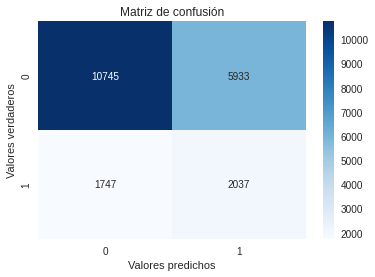

In [55]:
y_pred_lr = lr_model.predict(X_test)
y_pred_lr_proba = lr_model.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred_lr)

In [56]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.64      0.74     16678
           1       0.26      0.54      0.35      3784

    accuracy                           0.62     20462
   macro avg       0.56      0.59      0.54     20462
weighted avg       0.75      0.62      0.66     20462



### ---> Decision Tree Classifier

In [57]:
%%timeit
y_pred_dt = dt_model.predict(X_test)

3.82 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


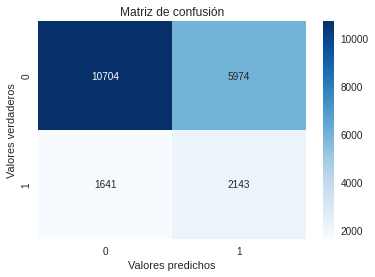

In [58]:
y_pred_dt = dt_model.predict(X_test)
y_pred_dt_proba = dt_model.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred_dt)

In [59]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74     16678
           1       0.26      0.57      0.36      3784

    accuracy                           0.63     20462
   macro avg       0.57      0.60      0.55     20462
weighted avg       0.76      0.63      0.67     20462



### ---> Xgboost

In [60]:
%%timeit
y_pred_xgboost = xgboost_model.predict(X_test)

88.1 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


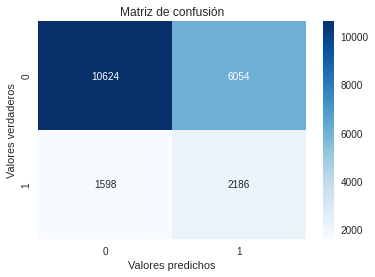

In [61]:
y_pred_xgboost = xgboost_model.predict(X_test)
y_pred_xgboost_proba = xgboost_model.predict_proba(X_test)
plot_confusion_matrix(y_test, y_pred_xgboost)

In [62]:
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

           0       0.87      0.64      0.74     16678
           1       0.27      0.58      0.36      3784

    accuracy                           0.63     20462
   macro avg       0.57      0.61      0.55     20462
weighted avg       0.76      0.63      0.67     20462



### ---> Pycaret AutoML

In [63]:
top_models = compare_models(sort='Recall', 
                            fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.3229,0.5058,0.8195,0.1908,0.3090,0.0134,0.0310,0.2860
dt,Decision Tree Classifier,0.3265,0.5120,0.8063,0.1896,0.3065,0.0107,0.0259,0.3660
gbc,Gradient Boosting Classifier,0.3415,0.4970,0.7992,0.1923,0.3094,0.0168,0.0379,0.6480
ada,Ada Boost Classifier,0.3614,0.4986,0.7867,0.1955,0.3125,0.0239,0.0501,0.5700
qda,Quadratic Discriminant Analysis,0.5453,0.5805,0.5807,0.2222,0.3205,0.0729,0.0924,0.2520
lr,Logistic Regression,0.6359,0.6409,0.5308,0.2614,0.3503,0.1362,0.1528,0.9100
ridge,Ridge Classifier,0.6374,0.0000,0.5255,0.2612,0.3489,0.1353,0.1512,0.2600
lda,Linear Discriminant Analysis,0.6374,0.6405,0.5254,0.2611,0.3488,0.1352,0.1512,0.2200
svm,SVM - Linear Kernel,0.6411,0.0000,0.5101,0.2603,0.3445,0.1320,0.1462,0.2280
rf,Random Forest Classifier,0.5039,0.4819,0.4463,0.1737,0.2449,-0.0222,-0.0289,0.6660


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

En el caso en el que quisiéramos replicar de cuenta propia los modelos en Skit-Learn podríamos hacerlo pues Pycaret nos brinda la posibilidad de tener la descripción de todo el pipeline implementado para llegar a dicho resultado con la función `get_config('pipeline)`:

In [64]:
get_config('pipeline')

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('ordinal_encoding',
                 TransformerWrapper(exclude=None, include=['TIPOVUELO'],
                                    transformer=OrdinalEncoder(cols=['TIPOVUELO'],
                                                               drop_invariant=False,
                                                               handle_missing='return_nan',
                                                               handle_unknown='value',
                                                               mapping=[{'col': 'TIPOVUELO',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': I      0
N      1
NaN   -1
dtype: int64}],
                                                               return_df=True,
                                                               ver...
                                                                   return_df=True,
                                                                   sigma=None,
                                                                   verbose=0))),
                ('balance',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                              n_jobs=None,
                                                                              random_state=None,
                                                                              sampling_strategy='auto')))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

## 05.03. Elección del modelo en particular

El modelo que presento el mejor balance entre las métricas descritas y el tiempo de predicción fue en nuestro caso fue el `Logistic Regression` con un `recall` de 0.54 para la clase positiva, un `F1-Score` de 0.35 para la clase positiva y un `accuracy` de 0.62. Si bien los modelos restantes tienen respecto a las métricas un desempeño sutilmente superior (en 1 punto porcentual aprox), el tiempo de predicción es drásticamente menor (731 µs vs 3 y 55 ms) por lo cual lo hace de manera integral un mejor modelo evaluando su desempeño en conjunto.

## 05.04. Variables que más influyen en la predicción

Aprovechando la funcionalidad de Pycaret que nos permite obtener de manera simple el gráfico para el feature importance del modelo `Logistic Regression` podemos observar que las características se habían estimado en el `numeral 03.07.` (destino y aerolínea, seguidas por dia de semana) son efectivamente las que mayor influencia presentan en la predicción.

In [65]:
lr_classifier = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6366,0.6378,0.5243,0.2604,0.3480,0.1340,0.1497
1,0.6373,0.6477,0.5351,0.2635,0.3531,0.1399,0.1569
2,0.6391,0.6443,0.5289,0.2632,0.3515,0.1389,0.1551
3,0.6339,0.6468,0.5549,0.2656,0.3592,0.1455,0.1648
4,0.6325,0.6277,0.5108,0.2543,0.3395,0.1229,0.1373
Mean,0.6359,0.6409,0.5308,0.2614,0.3503,0.1362,0.1528
Std,0.0024,0.0074,0.0145,0.0039,0.0065,0.0076,0.0091


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

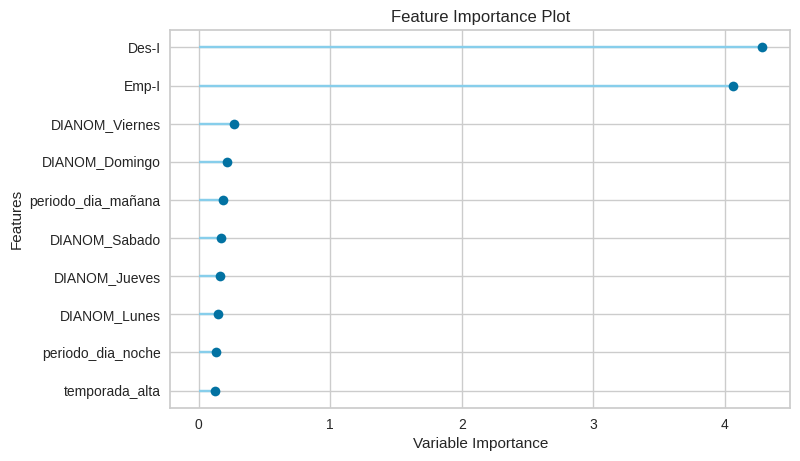

In [66]:
plot_model(lr_classifier, plot = 'feature')

## 05.05. Posibles mejoras al modelo para incrementar su performance

En relación a la mejora del performance del modelo podríamos explorar diversos enfoques basados en los datos y en las características de los modelos. Por otra parte podríamos tener mejoras, que aunque no tienen que ver explícitamente con su performance, si tienen que ver con la industrialización y consumo del modelo.



### ---> Mejoras en relación a los datos:
- **Datos existentes:** Podemos explorar con mayor detalle diferentes alternativas de encoding para las diferentes categorías y la selección de los features de mayor relevancia, reduciendo así el tamaño de los datasets de entrenamiento y evaluación y con ello el tiempo de estimación del modelo, mientras mantenemos o incrementamos sus métricas objetivo.
- **Datos complementarios (Inclusión de información complementaría y relevante de negocio):** podría indagarse con las personas de negocio si existen otros features que pudieran tenerse, y que aunque no se incluyeron en el dataset, podrían presentar gran relevancia para la estimación de los atrasos, y por ende de la mejora del performance. El tipo de aeronave (características de mantenimiento y operaciones), la composición de los vuelos en relación con el tipo de tiquete (manejo de gate y abordaje), la procedencia del vuelo anterior (retrasos debido a otros arribos), etc.

### ---> Mejoras en relación a los modelos:
- **Optimización de hiperparámetros:** Los modelos propuestos son modelos base que fueron entrenados con sus características por defecto. Haciendo uso del `grid search` y del `random search`, podríamos generar algunos pipelines que nos permitieran evaluar diferentes configuraciones de hiperparametros, y elegir con ello los que presentan un mejor performance.
- **Técnicas para tratar el desbalance de los datos:** si bien tuvimos en cuenta el desbalance de los datos tanto en el train test split, así como en los parámetros de los modelos, podrían evaluarse otras técnicas de sampleo (oversampling, undersampling) para saber si una composición diferente de los datos puede dar lugar a una mejora en la estimación.


### ---> Mejoras en relación a la industrialización y consumo del modelo:
- **Unificación de pilelines:** Si bien presentamos 2 secciones de transformación basadas en pipeline, y posteriormente una sección de estimación, podríamos agregar estas etapas en un único pipeline que puede generar todo el proceso de principio a fin. Esto nos permitirá almacenarlo como un único elemento que puede ser llamado para que directamente a partir de un dato de entrada realice la estimación tras pasar por todas sus etapas.
- **Registro de los experimentos y modelos evaluados**: podríamos tener un versionamiento de los diferentes experimentos y modelos evaluados si empleamos una herramienta como MLFlow para el tracking de toda la etapa de desarrollo del modelo.
- **Desarrollo de un API para consumo del modelo**En el caso que quisiéramos disponibilizar el modelo para su consumo podríamos emplear herramientas como Flask o FastAPI para crear un API que permitiera consumir el modelo.